In [1]:
# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")
np.random.seed(0)

In [2]:
df = pd.read_csv('test_data.csv')
df.head()

,t,l
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [4]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import codecs


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [6]:
label_names = ["l"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['t'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)


In [7]:
from sklearn.utils import shuffle 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

raw_docs_train = train_df['t'].tolist()
raw_docs_test = test_df['t'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 2001/2001 [00:00<00:00, 8057.41it/s]


tokenizing input data...
dictionary size:  2306


## Fastext


In [ ]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [20]:
embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1999996it [02:27, 13581.75it/s]

found 1999996 word vectors


### LSTM

In [21]:
# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [22]:
#embedding matrix

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 47


In [23]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['currecy' "n't" '1£' '1£' 'stillpending' 'redeposied' "'pending"
 'tranasaction' 'moeney' '€10']


In [24]:
from keras.layers import BatchNormalization
import tensorflow as tf

def create_lstm_model():
  model_lstm = tf.keras.Sequential()
  model_lstm.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
  # model.add(SpatialDropout1D(0.7))
  model_lstm.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
  model_lstm.add(Dense(128,activation='relu'))
  model_lstm.add(Dense(77, activation='softmax'))
  model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  return model_lstm


In [25]:
model_lstm_ft = create_lstm_model()
model_lstm_ft.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           692100    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 77)                9933      
                                                                 
Total params: 1,174,225
Trainable params: 482,125
Non-trainable params: 692,100
_________________________________________________________________


In [26]:
# from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_ft.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [27]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_lstm_ft.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)



Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 10s 193ms/step - loss: 4.2743 - accuracy: 0.0461 - val_loss: 4.1318 - val_accuracy: 0.0604
Epoch 2/40
22/22 [==============================] - 4s 180ms/step - loss: 3.8528 - accuracy: 0.1162 - val_loss: 3.2998 - val_accuracy: 0.2066
Epoch 3/40
22/22 [==============================] - 4s 179ms/step - loss: 2.9980 - accuracy: 0.2669 - val_loss: 2.2429 - val_accuracy: 0.4048
Epoch 4/40
22/22 [==============================] - 4s 172ms/step - loss: 2.2600 - accuracy: 0.4081 - val_loss: 1.6620 - val_accuracy: 0.5344
Epoch 5/40
22/22 [==============================] - 4s 180ms/step - loss: 1.8314 - accuracy: 0.4967 - val_loss: 1.3618 - val_accuracy: 0.6152
Epoch 6/40
22/22 [==============================] - 4s 176ms/step - loss: 1.5734 - accuracy: 0.5685 - val_loss: 1.1301 - val_accuracy: 0.6697
Epoch 7/40
22/22 [==============================] - 4s 185ms/step - loss: 1.3873 - accuracy: 0.6090 - val_loss: 0.9961 - val_accuracy: 0.7089
Epoch 8/40
22/22

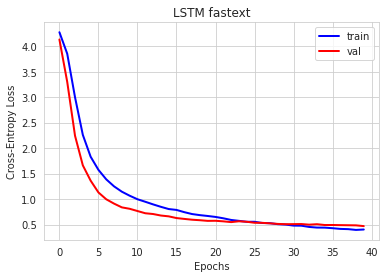

In [28]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM fastext')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

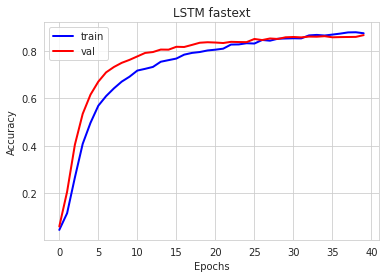

In [29]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM fastext')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [30]:
predictions = model_lstm_ft.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,14,25
8601,59,59
2545,15,15
8697,5,5
...,...,...
2769,66,66
5065,26,26
8287,17,76
7986,58,58


In [31]:
import sklearn

print("Accuracy With fastText LSTM:")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With fastText LSTM:
0.8860569715142429


### CNN

In [32]:
num_filters = 64 

In [33]:
#CNN architecture
def create_cnn_model():
  model_cnn = Sequential()
  model_cnn.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_cnn.add(MaxPooling1D(2))
  model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_cnn.add(GlobalMaxPooling1D())
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
  model_cnn.add(Dense(77, activation='softmax'))

  adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model_cnn


In [34]:
model_cnn_ft = create_cnn_model()  
model_cnn_ft.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 300)           692100    
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 64)            134464    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 64)            28736     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_cnn_ft.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [36]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_cnn_ft.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 9s 24ms/step - loss: 4.3188 - accuracy: 0.0211 - val_loss: 4.2488 - val_accuracy: 0.0450
Epoch 2/40
22/22 [==============================] - 0s 8ms/step - loss: 4.1456 - accuracy: 0.0543 - val_loss: 3.9420 - val_accuracy: 0.1175
Epoch 3/40
22/22 [==============================] - 0s 8ms/step - loss: 3.7767 - accuracy: 0.1107 - val_loss: 3.4316 - val_accuracy: 0.2178
Epoch 4/40
22/22 [==============================] - 0s 7ms/step - loss: 3.2747 - accuracy: 0.2062 - val_loss: 2.8241 - val_accuracy: 0.3682
Epoch 5/40
22/22 [==============================] - 0s 9ms/step - loss: 2.7463 - accuracy: 0.3078 - val_loss: 2.2379 - val_accuracy: 0.4748
Epoch 6/40
22/22 [==============================] - 0s 7ms/step - loss: 2.3235 - accuracy: 0.3830 - val_loss: 1.7883 - val_accuracy: 0.5835
Epoch 7/40
22/22 [==============================] - 0s 9ms/step - loss: 1.9736 - accuracy: 0.4663 - val_loss: 1.5139 - val_accuracy: 0.6418
Epoch 8/40
22/22 [============

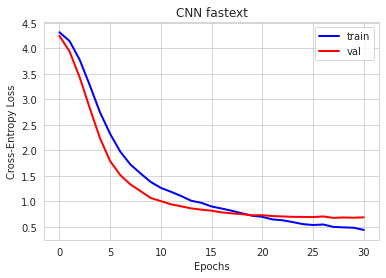

In [37]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN fastext')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

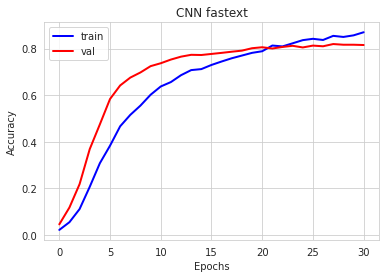

In [38]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN fastext')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [39]:
predictions = model_cnn_ft.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,14,25
8601,59,59
2545,15,15
8697,5,5
...,...,...
2769,66,66
5065,26,26
8287,32,76
7986,58,58


In [40]:
import sklearn

print("Accuracy With fastText CNN :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With fastText CNN :
0.8175912043978011


### CNN + LSTM

In [41]:
def create_cnn_lstm_model():
  model_mix = Sequential()
  model_mix.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model_mix.add(Dropout(0.2))
  model_mix.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_mix.add(MaxPooling1D(pool_size=4))
  model_mix.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
  model_mix.add(Dense(128,activation='relu'))
  model_mix.add(Dense(77, activation='softmax'))
  model_mix.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  return model_mix


In [42]:
model_mix_ft = create_cnn_lstm_model()

In [43]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_mix_ft.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 6s 89ms/step - loss: 4.3114 - accuracy: 0.0241 - val_loss: 4.2337 - val_accuracy: 0.0404
Epoch 2/40
22/22 [==============================] - 1s 62ms/step - loss: 4.1157 - accuracy: 0.0586 - val_loss: 3.7992 - val_accuracy: 0.1387
Epoch 3/40
22/22 [==============================] - 1s 60ms/step - loss: 3.5190 - accuracy: 0.1566 - val_loss: 2.8367 - val_accuracy: 0.2903
Epoch 4/40
22/22 [==============================] - 1s 61ms/step - loss: 2.7147 - accuracy: 0.2810 - val_loss: 2.0910 - val_accuracy: 0.4073
Epoch 5/40
22/22 [==============================] - 1s 62ms/step - loss: 2.1692 - accuracy: 0.3931 - val_loss: 1.6526 - val_accuracy: 0.5102
Epoch 6/40
22/22 [==============================] - 1s 59ms/step - loss: 1.8064 - accuracy: 0.4701 - val_loss: 1.3428 - val_accuracy: 0.6018
Epoch 7/40
22/22 [==============================] - 1s 61ms/step - loss: 1.5739 - accuracy: 0.5292 - val_loss: 1.1334 - val_accuracy: 0.6697
Epoch 8/40
22/22 [======

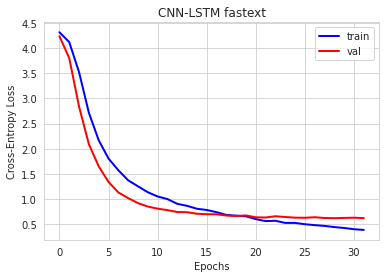

In [44]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM fastext')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

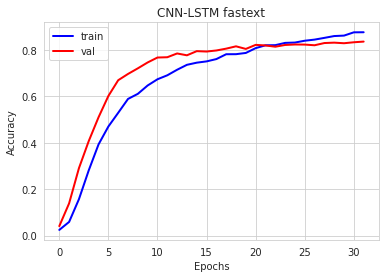

In [45]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM fastext')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [46]:
predictions = model_cnn_ft.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,14,25
8601,59,59
2545,15,15
8697,5,5
...,...,...
2769,66,66
5065,26,26
8287,32,76
7986,58,58


In [47]:
import sklearn

print("Accuracy With fastText CNN-LSTM :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With fastText CNN-LSTM :
0.8175912043978011
